# Gradient Descent for Logistic Regression

Just as with Linear Regression, the **Gradient Descent** algorithm can be used to find parameters 'w' and 'b' as to minimize the value of the cost function `J(w,b)`.

In [29]:
import math, copy
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import importlib

# Custom scripts imports
# Adding the directory to sys.path
sys.path.insert(0, os.path.abspath('../'))

# Import the modules after
from src.visualization import visualize
from src.models import predict_model

# Now reload using the module reference, for future changes.
importlib.reload(visualize)
importlib.reload(predict_model)

from src.visualization.visualize import plot_data, plt_prob
from src.models.predict_model import sigmoid
from src.models.train_model import compute_cost_logistic_sq_err

Just as with the decision boundary notebook, we can start by creating a trivial yet exemplifying datasets, both for the training samples matrix (X) and target values vector (y)

In [5]:
# Create training set with potential tumour characteristics (ie, size, etc)
X_train = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
# Create the target values vector with the classification for tumours matching the training set
y_train = np.array([0, 0, 0, 1, 1, 1])

The plot for the dataset and its target is as follows:

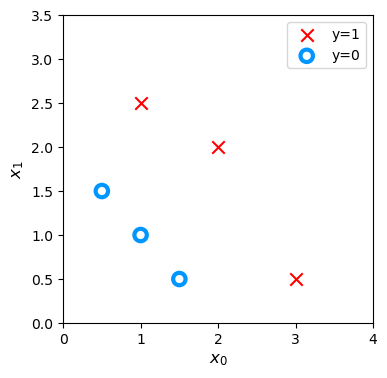

In [6]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_data(X_train, y_train, ax)

ax.axis([0, 4, 0, 3.5])
ax.set_ylabel('$x_1$', fontsize=12)
ax.set_xlabel('$x_0$', fontsize=12)
plt.show()

## Logistic Gradient Descent

Gradient Descent utilises the gradient calculation as follows:

$$\begin{align*}
&\text{repeat until convergence:} \; \lbrace \\
&  \; \; \;w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1} \\ 
&  \; \; \;  \; \;b = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \\
&\rbrace
\end{align*}$$

Where each iteration performs simultaneous updates on $w_j$ for all $j$, where
$$\begin{align*}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2} \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3} 
\end{align*}$$

* m is the number of training examples in the data set      
* $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target
* For a logistic regression model  
    $z = \mathbf{w} \cdot \mathbf{x} + b$  
    $f_{\mathbf{w},b}(x) = g(z)$  
    where $g(z)$ is the sigmoid function:  
    $g(z) = \frac{1}{1+e^{-z}}$   
    

The implementation of the algorithm requires two code functions:

- **Compute current gradient**, which is the calculation of the 'current' gradient, related to equations (2) and (3) above.
- **Gradient Descent**, the algorithm per se, which uses the above function, and relates to (1) in above expresssions

In [14]:
def compute_gradient_logistic_regression(X, y, w, b):
    """
    Computes the gradient for logistic regression 
 
    Args:
      X (ndarray (m,n): Data [Matrix - 2D numpy array], m examples with n features
      y (ndarray (m,)): target values [Vector - 1D numpy array]
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
    Returns
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape
    dj_dw = np.zeros((n,))
    dj_db = 0.
    for i in range(m):
        # The derivative, in terms of f_wb_i, is the sigmoid applied to the linear model, as seen in theory.
        f_wb_i = sigmoid(np.dot(X[i],w) + b)
        error_i = f_wb_i - y[i]
        # Do the derivative per feature, at the column level (j index of n in matrix indices)
        for j in range(n):
          dj_dw[j] += error_i * X[i,j]
        dj_db += error_i
    dj_dw /= m
    dj_db /= m
    return dj_db, dj_dw

We can quickly check the implementation above with the following data:

In [15]:
X_tmp = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_tmp = np.array([0, 0, 0, 1, 1, 1])
w_tmp = np.array([2.,3.])
b_tmp = 1.
dj_db_tmp, dj_dw_tmp = compute_gradient_logistic_regression(X_tmp, y_tmp, w_tmp, b_tmp)
print(f"dj_db: {dj_db_tmp}" )
print(f"dj_dw: {dj_dw_tmp.tolist()}" )

dj_db: 0.49861806546328574
dj_dw: [0.498333393278696, 0.49883942983996693]


Using above method to compute the gradients per parameter, the following is an implementation for the gradient descent, which implements the formula labeled as (1) in above cells:

In [20]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters):
    """
    Performs batch gradient descent
    
    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters  
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      num_iters (scalar) : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter 
    """
    # Array to store cost at iterations, to display as the algorithm run
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    # Run the algorithm as per the number of iterations passed
    for i in range(num_iters):
      # Calculate gradients per current iteration
      dj_db, dj_dw = compute_gradient_logistic_regression(X, y, w, b)
      # Adjust values for w and b
      w = w - alpha * dj_dw
      b = b - alpha * dj_db

      # Save cost J at each iteration
      if i<100000:      # prevent resource exhaustion 
        J_history.append( compute_gradient_logistic_regression(X, y, w, b) )

      # Print cost every at intervals 10 times or as many iterations if < 10
      if i% math.ceil(num_iters / 10) == 0:
        print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
    #return final w,b and J history for plotting
    return w, b, J_history     

The following runs the gradient descent algorithm using above functions:

In [21]:
w_tmp  = np.zeros_like(X_train[0])
b_tmp  = 0.
alph = 0.1
iters = 10000

w_out, b_out, _ = gradient_descent(X_train, y_train, w_tmp, b_tmp, alph, iters) 
print(f"\nupdated parameters: w:{w_out}, b:{b_out}")

Iteration    0: Cost (0.014924742767851254, array([-0.22449108, -0.14601523]))   
Iteration 1000: Cost (0.03292263785587346, array([-0.01154724, -0.01179442]))   
Iteration 2000: Cost (0.017933890941894477, array([-0.00639134, -0.0064637 ]))   
Iteration 3000: Cost (0.01219290340280725, array([-0.00437133, -0.00440444]))   
Iteration 4000: Cost (0.009205288270528337, array([-0.00331049, -0.00332914]))   
Iteration 5000: Cost (0.007382936755160792, array([-0.00266019, -0.00267204]))   
Iteration 6000: Cost (0.006158304660621156, array([-0.00222181, -0.00222997]))   
Iteration 7000: Cost (0.005279886586599484, array([-0.00190669, -0.00191261]))   
Iteration 8000: Cost (0.004619558128642703, array([-0.00166943, -0.00167391]))   
Iteration 9000: Cost (0.0041053232770014575, array([-0.00148444, -0.00148794]))   

updated parameters: w:[5.28123029 5.07815608], b:-14.222409982019837


The plot for the results of the gradient descent run is as follows:

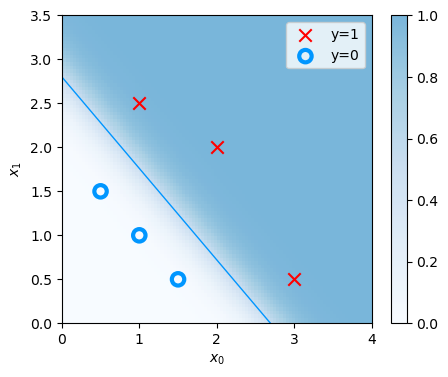

In [31]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
# plot the probability 
plt_prob(ax, w_out, b_out)

# Plot the original data
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_0$')   
ax.axis([0, 4, 0, 3.5])
plot_data(X_train,y_train,ax)

# Plot the decision boundary
x0 = -b_out/w_out[0]
x1 = -b_out/w_out[1]
ax.plot([0,x0],[x1,0], c="#0096ff", lw=1)
plt.show()

We can draw the following conclusions from the plot above:
- The shading is the probability of a positive match or y = 1
- The decision bounday is the line at x0, x1 where the probability is 0.5 (P(y=1|y=0: 0,5))